# Neural Network Model Tuning

- Alejandro Hohmann
- Bhanu Muvva
- Chunxia Tong

The purpose of this notebook is with new features and hyperparameter tuning on Neural Network

# Table of Contents

### - [Neural Net Architecture](#NN)
- imported from .py file

### - [Initial Grid Search for HyperParameters](#HYPER)
- selects optimization metric

### - [SHAP Values for Feature Importance](#SHAP)
        - used for narrowing down to most important features

### - [Feature Selection Using SHAP order](#FEATURE)

### - [Best Model with Epochs](#BEST)
- saves values to .json file and .pth file

### - [Confusion Matrix](#MATRIX)
- assesses probability distribution and states

In [1]:
# assign seed now for consistency any time it needs to be used
seed=27

In [1]:
# file structure libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import pickle

# # visualization libraries
from matplotlib import pyplot as plt
#plt.style.use('seaborn-v0_8-pastel')
plt.style.use('seaborn-v0_8-darkgrid')
#plt.style.use('bmh')
#plt.style.use('dark_background')
#plt.style.use('fivethirtyeight')
%matplotlib inline
# import seaborn as sns

# # ML libraries
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay#, roc_curve
# from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# # for sigmoid function, in case we need to manually implement in LR
# from scipy.stats import logistic

import torch
import torch.nn as nn
import torch.optim as optim
import shap

In [2]:
# start of notebook
from datetime import datetime
start_time = datetime.now()
print('start time:', str(start_time))

start time: 2023-06-07 23:51:22.948141


In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.device_count()

4

In [5]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti


In [6]:
# our system has 8 GPUs
# we won't need them all at the same time but can be helpful

device_0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_1 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device_2 = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device_3 = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device_4 = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
device_5 = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
device_6 = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
device_7 = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

devices = [
    device_0,
    device_1,
    device_2,
    device_3,
    device_4,
    device_5,
    device_6,
    device_7,
]

In [7]:
# SELECT YOUR DEVICE FOR THIS NOTEBOOK
idx = 0
device = devices[idx] # change index to select
device

device(type='cuda', index=0)

## Neural Net <a id="NN">

In [8]:
# load in the model class
import sys
sys.path.append("../../app/model/")
import ModelNN as Net

In [9]:
import inspect

# we've defined multiple architectures to select from
for name, obj in inspect.getmembers(Net):
    if inspect.isclass(obj):
        print(obj)

<class 'ModelNN.Net'>
<class 'ModelNN.OneLayer'>
<class 'ModelNN.ThreeLayer'>
<class 'ModelNN.TwoLayer'>


In [10]:
# LOAD IN DATA
X_train_df, X_test_df, y_train_df, y_test_df = pickle.load(open("../../data/train_test_data.pkl", "rb"))

print("X_train: ", X_train_df.shape)
print("X_test: ", X_test_df.shape)
print("\n")
print("y_train: ", y_train_df.shape)
print("y_test: ", y_test_df.shape)

X_train:  (1192, 13)
X_test:  (271, 13)


y_train:  (1192,)
y_test:  (271,)


# Grid Search for HyperParameter Tuning <a id="HYPER">
    
- optimize grid search with different model metrics to decide on optimal path forward

In [11]:
# list of functions
metrics =[
    recall_score,
    f1_score,
    roc_auc_score,
]

# create dataframe to track performance on metric criteria
index=[metric.__name__ for metric in metrics]
columns=[
    'test_accuracy',
    'test_precision',
    'test_recall',
    'test_f1_score',
    'test_auc',
    'training_loss',
    'validation_loss',
    'epochs',
    'hyper_params' # this will be a dictionary
]

param_df = pd.DataFrame(index=index,
                        columns=columns)

param_df

,test_accuracy,test_precision,test_recall,test_f1_score,test_auc,training_loss,validation_loss,epochs,hyper_params
recall_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f1_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
roc_auc_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# configured to be consistent in rest of notebook
# can scroll down and customize at each training step
#n_epochs = 100
#n_epochs = 250
#n_epochs = 500
#n_epochs = 750
n_epochs = 1000
#n_epochs = 2500
#n_epochs = 5000
print(n_epochs)

1000


In [13]:
%%time
# GRID SEARCH CV for hyperpameters
# looped over different performance metrics
if __name__ == '__main__':
    # data already loaded

    #scale the data X_train and X_test
    cols = X_train_df.columns
    sc = StandardScaler()
    # the "scaled" objects are still dataframes
    X_train_scaled = pd.DataFrame(sc.fit_transform(X_train_df), columns=cols)
    X_test_scaled = pd.DataFrame(sc.transform(X_test_df), columns=cols)

    # convert to tensor objects
    # send to gpu if available
    X_train_tensor = torch.tensor(X_train_scaled.values).float().to(device)
    y_train_tensor = torch.tensor(y_train_df.values).float().view(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test_scaled.values).float().to(device)
    y_test_tensor = torch.tensor(y_test_df.values).float().view(-1, 1).to(device)
    
    # loop over evaluation metrics
    for metric in metrics:
        # instantiate at zer0 within the loop
        best_score = 0.0
        # score logic implemented after training run on hyperparameter search
    
        # GRID SEARCH
        # these are the hyperparameters to search through
        param_grid = {
        'hidden_size': [10, 50, 100, 250, 500],
        'dropout_rate': [0.05, 0.10, 0.15, 0.20],
        'lr': [0.0001, 0.001, 0.01],
        } 

        for params in ParameterGrid(param_grid):
            input_size = X_train_df.shape[1]
            hidden_size = params['hidden_size']
            learning_rate = params['lr']
            dropout_rate = params['dropout_rate']
            output_size = 1 # for our uses this will always be 0ne

            # instantiate the model class
            # send to gpu if available
            model = Net.OneLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
            #model = Net.TwoLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
            #model = Net.ThreeLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
            
            # make sure model is in training mode, calculates gradients etcs
            model.train()
            criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

            ## Train the Model ##

            for epoch in range(n_epochs):
                y_train_pred_proba = model(X_train_tensor)
                loss = criterion(y_train_pred_proba, y_train_tensor)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # turn off dropout etc
            model.eval()
            ## now "final" probability outputs from trained model ##
            y_train_pred_proba = model(X_train_tensor)
            y_test_pred_proba = model(X_test_tensor)     

            # loss on the final output
            # this isn't necessarily meaningful without seeing change over epochs 
            # can be handy reference
            # back to cpu / numpy
            train_loss = criterion(y_train_pred_proba, y_train_tensor).detach().cpu().numpy().flatten()[0]
            val_loss = criterion(y_test_pred_proba, y_test_tensor).detach().cpu().numpy().flatten()[0]

            # # convert these values back to pandas dtypes
            y_train_pred_proba = y_train_pred_proba.detach().cpu().numpy() # numpy goes back to cpu
            y_test_pred_proba = y_test_pred_proba.detach().cpu().numpy()   # numpy goes back to cpu 
            # also get their boolean values
            y_train_pred_bool = np.round(y_train_pred_proba)
            y_test_pred_bool = np.round(y_test_pred_proba)

            # calculate accuracy
            train_accuracy = accuracy_score(y_train_df, y_train_pred_bool.flatten())
            test_accuracy = accuracy_score(y_test_df, y_test_pred_bool.flatten())

            # calculate precision
            test_precision = precision_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)

            # calculate recall
            test_recall_score = recall_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)
            
            # calculate f1
            f1_test = f1_score(y_test_df, y_test_pred_bool)

            # extract AUC for printing
            auc_test = roc_auc_score(y_test_df, y_test_pred_proba)
            
            # metrics have already been calculated
            # but this is where metric loop logic kicks in
            if metric.__name__ == 'recall_score':
                score = test_recall_score
            elif metric.__name__ == 'f1_score':
                score = f1_test
            elif metric.__name__ == 'roc_auc_score':
                score = auc_test

            # evaluate parameters on given metric and log parameters
            if score > best_score:
                best_score = score
                best_params = params
                
                # and if this is the best, update the dateframe with the given metrics
                param_df.loc[metric.__name__, 'test_accuracy'] = test_accuracy
                param_df.loc[metric.__name__, 'test_precision'] = test_precision
                param_df.loc[metric.__name__, 'test_recall'] = test_recall_score
                param_df.loc[metric.__name__, 'test_f1_score'] = f1_test
                param_df.loc[metric.__name__, 'test_auc'] = auc_test
                param_df.loc[metric.__name__, 'training_loss'] = train_loss#.detach().numpy().flatten()[0]
                param_df.loc[metric.__name__, 'validation_loss'] = val_loss#.detach().numpy().flatten()[0]
                param_df.loc[metric.__name__, 'epochs'] = n_epochs         
                # to insert hyparams into df...pack as a list of tuples
                best_params = [tuple(pair) for pair in best_params.items()]
                # insert as a list
                # to unpack later call... `dict(best_params)`
                param_df.loc[metric.__name__, 'hyper_params'] = best_params

        # save model weights
        # model_name = model.__class__.__name__
        # torch.save(model.state_dict(), f'{model_name}.pth')     

print(model.__class__.__name__)
print("trained on: ", device)
print("\n")
param_df.T

OneLayer
trained on:  cuda:0


CPU times: user 3min 38s, sys: 3.9 s, total: 3min 42s
Wall time: 3min 40s


,recall_score,f1_score,roc_auc_score
test_accuracy,0.870849,0.870849,0.863469
test_precision,0.685185,0.672414,0.673077
test_recall,0.672727,0.709091,0.636364
test_f1_score,0.678899,0.690265,0.654206
test_auc,0.883333,0.871633,0.890488
training_loss,0.209636,0.02799,0.137709
validation_loss,0.361897,1.580141,0.481453
epochs,1000,1000,1000
hyper_params,"[(dropout_rate, 0.05), (hidden_size, 50), (lr,...","[(dropout_rate, 0.05), (hidden_size, 500), (lr...","[(dropout_rate, 0.2), (hidden_size, 50), (lr, ..."


### Decision Criteria
- the models may have similar performance metrics
- choosing based on validation loss may prevent overfitting
    - in this case, optimizing on AUC has the lowest validation loss, while the other two performance metrics have incredibly highloss.
    - this is an indication that the models created by the other metrics overfit the training data.

### Notes along the way
- **100 epochs optimized on recall had `0.98 recall score!`**

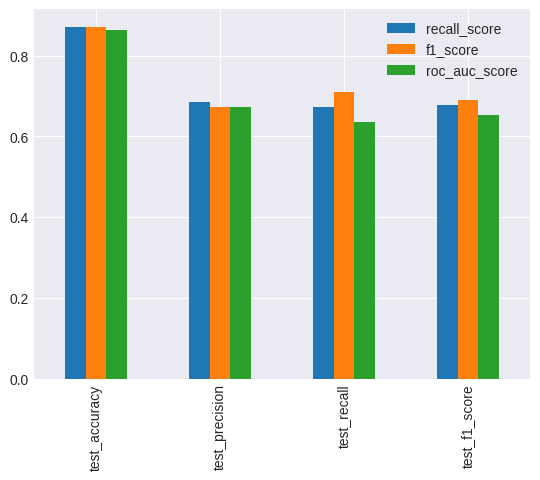

In [14]:
param_df.iloc[:,:4].T.plot(kind='bar');

# SHAP Values for feature selection<a id="SHAP">

- First train model with best hyperparameters / tuning metric

- Examine the Shap values for feature importance
    - we likely need to reduce the number of features to prevent overfitting

In [15]:
# # manually selecting
# idx = 2
# chosen_metric = metrics[idx].__name__

# automated selection
lowest_loss_metric = param_df['validation_loss'].astype(float).idxmin()
chosen_metric = lowest_loss_metric

# select based on above
print(chosen_metric)
chosen_params = dict(param_df.loc[chosen_metric, 'hyper_params'])
chosen_params

recall_score


{'dropout_rate': 0.05, 'hidden_size': 50, 'lr': 0.001}

In [16]:
# n_epochs = 750
n_epochs = n_epochs
print(n_epochs)

1000


Architecture:  OneLayer
hyperparameters:
{'dropout_rate': 0.05, 'hidden_size': 50, 'lr': 0.001}


Epochs: 1000
Training loss: 0.23794397711753845
Validation loss: 0.34880900382995605


Training Accuracy: 0.9001677852348994
Test Accuracy: 0.8339483394833949


Test Recall: 0.6041666666666666
Test Recall: 0.5272727272727272
Test F1 Score: 0.5631067961165047


Test AUC: 0.8825757575757576


CPU times: user 1.52 s, sys: 48.2 ms, total: 1.57 s
Wall time: 1.49 s


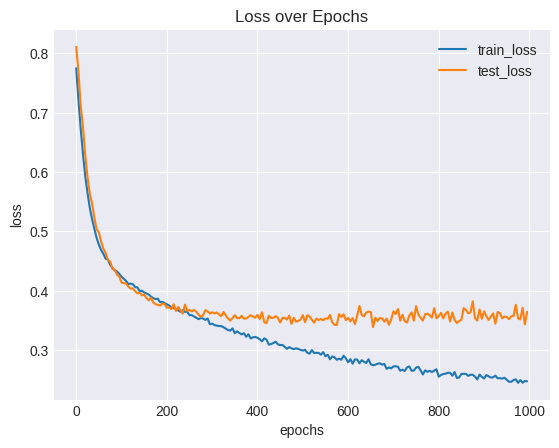

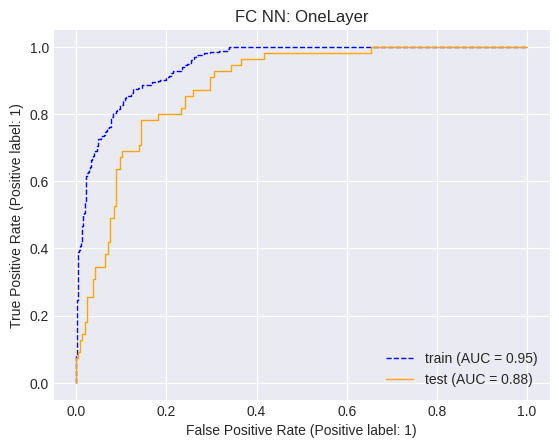

In [17]:
%%time
# SHAP VALUE EXTRACTION
if __name__ == '__main__':
    # data already loaded

    #scale the data X_train and X_test
    cols = X_train_df.columns
    sc = StandardScaler()
    # the "scaled" objects are still dataframes
    X_train_scaled = pd.DataFrame(sc.fit_transform(X_train_df), columns=cols)
    X_test_scaled = pd.DataFrame(sc.transform(X_test_df), columns=cols)

    # convert to tensor objects
    # send to gpu if available
    X_train_tensor = torch.tensor(X_train_scaled.values).float().to(device)
    y_train_tensor = torch.tensor(y_train_df.values).float().view(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test_scaled.values).float().to(device)
    y_test_tensor = torch.tensor(y_test_df.values).float().view(-1, 1).to(device)
    
    # HYPER PARAMETERS FROM DECISION CRITERIA
    input_size = X_train_df.shape[1]
    hidden_size = chosen_params['hidden_size']
    learning_rate = chosen_params['lr']
    dropout_rate = chosen_params['dropout_rate']
    output_size = 1 # for our uses this will always be 0ne

    # instantiate the model class
    # send to gpu if available
    model = Net.OneLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
    #model = Net.TwoLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
    #model = Net.ThreeLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
    
    # make sure model is in training mode, calculates gradients etcs
    model.train()
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

    ## Train the Model ##
    
    # create empty df to track loss over epochs
    loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])
    
    for epoch in range(n_epochs):
        y_train_pred_proba = model(X_train_tensor)
        loss = criterion(y_train_pred_proba, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # track loss for plotting
        if epoch%5 ==0:
            y_train_pred_proba = model(X_train_tensor)
            y_test_pred_proba = model(X_test_tensor) 

            train_loss = criterion(y_train_pred_proba, y_train_tensor)
            val_loss = criterion(y_test_pred_proba, y_test_tensor)
            
            loss_df.loc[epoch, 'train_loss'] = train_loss.detach().cpu().numpy().flatten()[0]
            loss_df.loc[epoch, 'test_loss'] = val_loss.detach().cpu().numpy().flatten()[0]

    # turn off dropout etc
    model.eval()
    ## now "final" probability outputs from trained model ##
    y_train_pred_proba = model(X_train_tensor)
    y_test_pred_proba = model(X_test_tensor)     

    # loss on the final output
    # this isn't necessarily meaningful without seeing change over epochs 
    # can be handy reference
    # back to cpu / numpy
    train_loss = criterion(y_train_pred_proba, y_train_tensor).detach().cpu().numpy().flatten()[0]
    val_loss = criterion(y_test_pred_proba, y_test_tensor).detach().cpu().numpy().flatten()[0]

    # # convert these values back to pandas dtypes
    y_train_pred_proba = y_train_pred_proba.detach().cpu().numpy() # numpy goes back to cpu
    y_test_pred_proba = y_test_pred_proba.detach().cpu().numpy()   # numpy goes back to cpu
    # also get their boolean values
    y_train_pred_bool = np.round(y_train_pred_proba)
    y_test_pred_bool = np.round(y_test_pred_proba)

    # calculate accuracy
    train_accuracy = accuracy_score(y_train_df, y_train_pred_bool.flatten())
    test_accuracy = accuracy_score(y_test_df, y_test_pred_bool.flatten())
    
    # calculate precision
    test_precision = precision_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)
    
    # calculate recall
    test_recall_score = recall_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)
    
    # calculate f1
    f1_test = f1_score(y_test_df, y_test_pred_bool)

    # extract AUC for printing
    auc_test = roc_auc_score(y_test_df, y_test_pred_proba)      
   
    ## save final model weights
    model_name = model.__class__.__name__
    # torch.save(model.state_dict(), f'{model_name}.pth')     

    print('Architecture: ', model_name)
    print('hyperparameters:')
    print(chosen_params)
    print("\n")
    print(f"Epochs: {n_epochs}")
    print(f'Training loss: {train_loss}')
    print(f'Validation loss: {val_loss}')
    print("\n")

    # accuracy #
    # training accuracy
    train_accuracy = accuracy_score(y_train_df, y_train_pred_bool.flatten())
    print(f'Training Accuracy: {train_accuracy}')
    # testing accuracy
    test_accuracy = accuracy_score(y_test_df, y_test_pred_bool.flatten())
    print(f'Test Accuracy: {test_accuracy}')
    print("\n")

    # Precision
    print(f'Test Recall: {test_precision}')
    
    # Recall
    print(f'Test Recall: {test_recall_score}')
    
    # f1
    print(f'Test F1 Score: {f1_test}')
    print("\n")
    
    # AUC
    print(f'Test AUC: {auc_test}')
    print("\n")
    
    
    # PLOTS
    fig = loss_df.plot()
    fig.set_xlabel('epochs')
    fig.set_ylabel('loss')
    fig.set_title('Loss over Epochs');
    
    # and plot AUC
    fig, ax = plt.subplots()

    RocCurveDisplay.from_predictions(y_train_df, 
                                     y_train_pred_proba, 
                                     ax=ax, 
                                     linewidth=1, 
                                     color='blue', 
                                     name='train', 
                                     linestyle="dashed"
                                    );

    RocCurveDisplay.from_predictions(y_test_df,
                                     y_test_pred_proba,
                                     ax=ax, 
                                     linewidth=1, 
                                     color='orange', 
                                     name='test');

    plt.title(f'FC NN: {model_name}');

In [18]:
explainer = shap.DeepExplainer(model, X_train_tensor)
shap_values = explainer.shap_values(X_test_tensor)
print(shap_values.shape)
vals = np.abs(shap_values).mean(0)
shap_val_df = pd.DataFrame(data=vals, index=X_test_df.columns, columns=['vals'])
shap_val_df = shap_val_df.sort_values(by='vals', ascending=False)
shap_val_df

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


(271, 13)


,vals
peak_i15_mmh,0.127191
kf,0.054945
prophm23,0.046008
SuscFrac,0.042800
fire_interval,0.040599
SAV,0.039437
SedUn,0.032304
Extinction moisture content,0.031132
Fine fuel load,0.022129
LNDS_RISKS,0.020527


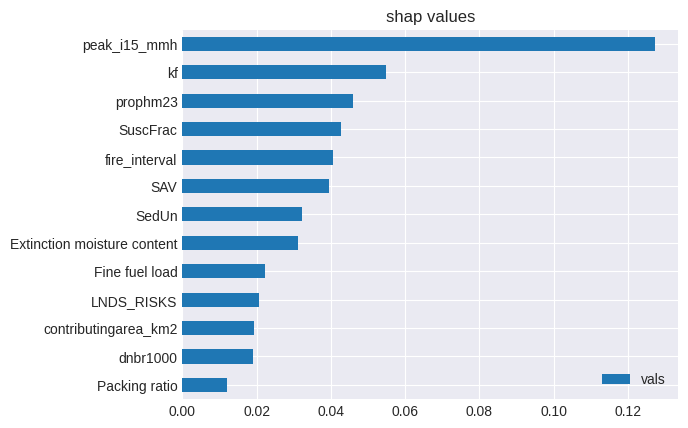

In [19]:
shap_val_df[::-1].plot(kind='barh', title='shap values');

In [20]:
feat_order = list(shap_val_df.index)
feat_order

['peak_i15_mmh',
 'kf',
 'prophm23',
 'SuscFrac',
 'fire_interval',
 'SAV',
 'SedUn',
 'Extinction moisture content',
 'Fine fuel load',
 'LNDS_RISKS',
 'contributingarea_km2',
 'dnbr1000',
 'Packing ratio']

In [21]:
# generate incrementally longer feature lists in order of importance
cumulative_feature_list = []
for i, feat in enumerate(feat_order, 1):
    cumulative_feature_list.append(feat_order[:i])
# just check the first few records to make sure they increment by one
cumulative_feature_list[:4]

[['peak_i15_mmh'],
 ['peak_i15_mmh', 'kf'],
 ['peak_i15_mmh', 'kf', 'prophm23'],
 ['peak_i15_mmh', 'kf', 'prophm23', 'SuscFrac']]

In [22]:
# exclude testing with just ONE feature
feat_of_feats = cumulative_feature_list[1:]
feat_of_feats[-1] # this should be ALL the features now

['peak_i15_mmh',
 'kf',
 'prophm23',
 'SuscFrac',
 'fire_interval',
 'SAV',
 'SedUn',
 'Extinction moisture content',
 'Fine fuel load',
 'LNDS_RISKS',
 'contributingarea_km2',
 'dnbr1000',
 'Packing ratio']

## Feature Selection Using Shap Order<a id="FEATURE">
- it performs hyperparameter grid search along with the features in shap ranked order

In [23]:
print(chosen_metric)
print(chosen_params)

recall_score
{'dropout_rate': 0.05, 'hidden_size': 50, 'lr': 0.001}


In [24]:
# n_epochs = 750
n_epochs = n_epochs
print(n_epochs)

1000


In [25]:
%%time
# GRID SEARCH WITH FEATURE SETS
if __name__ == '__main__':

    # GRID SEARCH
    param_grid = {
    'hidden_size': [10, 50, 100, 250, 500],
    'dropout_rate': [0.05, 0.10, 0.15, 0.20],
    'lr': [0.0001, 0.001, 0.01],
    'features': feat_of_feats # list of lists
    }
    
    best_accuracy = 0.0
    best_recall = 0.0
    best_auc = 0.0
    best_params ={}
    
    # loop over features
    # instantiate at zer0 before the loop
    best_score = 0.0
    
    for params in ParameterGrid(param_grid):      
        # Load data with feature subset
        
        # splitting already conducted
        # using df objects to avoid tensor issues
        X_train = X_train_df[params['features']]
        X_test = X_test_df[params['features']]
        y_train = y_train_df
        y_test = y_test_df

        #scale the data X_train and X_test
        cols = X_train.columns
        sc = StandardScaler()
        X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
        X_test = pd.DataFrame(sc.transform(X_test), columns=cols)

        # convert to tensor objects
        # send to gpu if available
        X_train_tensor = torch.tensor(X_train.values).float().to(device)
        y_train_tensor = torch.tensor(y_train.values).float().view(-1, 1).to(device)
        X_test_tensor = torch.tensor(X_test.values).float().to(device)
        y_test_tensor = torch.tensor(y_test.values).float().view(-1, 1).to(device)
        
        # hyperparameters grid search
        input_size = X_train.shape[1]
        hidden_size = params['hidden_size']
        learning_rate = params['lr']
        dropout_rate = params['dropout_rate']
        output_size = 1

        # instantiate the model class
        model = Net.OneLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
        #model = Net.TwoLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
        #model = Net.ThreeLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
        
        # make sure model is in training mode, calculates gradients etcs
        model.train()
        criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
         
        ## Train the Model ##

        for epoch in range(n_epochs):
            y_train_pred_proba = model(X_train_tensor)
            loss = criterion(y_train_pred_proba, y_train_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # turn off dropout etc
        model.eval()
        # now "final" outputs
        y_train_pred_proba = model(X_train_tensor)
        y_test_pred_proba = model(X_test_tensor)

        # loss on the final output
        # this isn't necessarily meaningful without seeing change over epochs 
        # can be handy reference
        # back to cpu / numpy
        train_loss = criterion(y_train_pred_proba, y_train_tensor).detach().cpu().numpy().flatten()[0]
        val_loss = criterion(y_test_pred_proba, y_test_tensor).detach().cpu().numpy().flatten()[0]

        # # convert these values back to pandas dtypes
        y_train_pred_proba = y_train_pred_proba.detach().cpu().numpy() # numpy goes back to cpu
        y_test_pred_proba = y_test_pred_proba.detach().cpu().numpy()   # numpy goes back to cpu
        # also get their boolean values
        # simply if a probability is above .5 it predicts a 1
        y_train_pred_bool = np.round(y_train_pred_proba)
        y_test_pred_bool = np.round(y_test_pred_proba)   
        
   
        # calculate accuracy
        train_accuracy = accuracy_score(y_train_df, y_train_pred_bool.flatten())
        test_accuracy = accuracy_score(y_test_df, y_test_pred_bool.flatten())

        # calculate precision
        test_precision = precision_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)
        
        # calculate recall
        test_recall_score = recall_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)
        
        # calculate f1
        f1_test = f1_score(y_test_df, y_test_pred_bool)

        # extract AUC for printing
        auc_test = roc_auc_score(y_test_df, y_test_pred_proba)
        
        # metrics have already been calculated
        # but this is where metric loop logic kicks in
        if chosen_metric == 'recall_score':
            score = test_recall_score
        elif chosen_metric == 'f1_score':
            score = f1_test
        elif chosen_metric == 'roc_auc_score':
            score = auc_test
        
        # evaluate features on given metric and log features / scores
        if score > best_score:
            best_score = score
            #chosen_features = feats
            best_params = params
                                 
            best_train_accuracy = train_accuracy
            best_test_accuracy = test_accuracy
            best_test_precision = test_precision
            best_test_recall_score = test_recall_score
            best_f1_test = f1_test
            best_auc_test = auc_test
            best_train_loss = train_loss
            best_val_loss = val_loss        

    ## save final model weights
    model_name = model.__class__.__name__
    # torch.save(model.state_dict(), f'{model_name}.pth')      
    print(model_name)
    print('with feature selection')
    print(len(best_params['features']), " features: ")
    print(best_params['features'])
    print('hyperparameters:')
    param_keys = ['dropout_rate', 'hidden_size', 'lr']
    for key in param_keys:
        print(key + ":", best_params[key])
    print("\n")
    print(f'Training loss: {best_train_loss}')
    print(f'Validation loss: {best_val_loss}')
    print("\n")

    # accuracy #
    # training accuracy
    print(f'Training Accuracy: {best_train_accuracy}')
    # testing accuracy
    print(f'Test Accuracy: {best_test_accuracy}')
    print("\n")

    # Recall
    print(f'Test Precision: {best_test_precision}')
    print("\n")
    
    # Recall
    print(f'Test Recall: {best_test_recall_score}')
    print("\n")
    
    # f1
    print(f'Test F1 Score: {best_f1_test}')
    print("\n")
    
    # AUC
    print(f'Test AUC: {best_auc_test}')
    print("\n")

OneLayer
with feature selection
10  features: 
['peak_i15_mmh', 'kf', 'prophm23', 'SuscFrac', 'fire_interval', 'SAV', 'SedUn', 'Extinction moisture content', 'Fine fuel load', 'LNDS_RISKS']
hyperparameters:
dropout_rate: 0.2
hidden_size: 10
lr: 0.0001


Training loss: 0.6881222724914551
Validation loss: 0.6354578733444214


Training Accuracy: 0.5746644295302014
Test Accuracy: 0.6346863468634686


Test Precision: 0.35333333333333333


Test Recall: 0.9636363636363636


Test F1 Score: 0.5170731707317073


Test AUC: 0.7988215488215488


CPU times: user 14min 34s, sys: 11.3 s, total: 14min 45s
Wall time: 14min 40s


In [26]:
# %%time
# # OG
# # FEATURE LOOP no grid search on hyper parameters
# if __name__ == '__main__':

#     # GRID SEARCH
#     param_grid = {
#     'hidden_size': [10, 50, 100, 250, 500],
#     'dropout_rate': [0.05, 0.10, 0.15, 0.20],
#     'lr': [0.0001, 0.001, 0.01],
#     'features': feat_of_feats # list of lists
#     }
    
#     best_accuracy = 0.0
#     best_recall = 0.0
#     best_auc = 0.0
#     best_params ={}
    
#     # loop over features
#     # instantiate at zer0 before the loop
#     best_score = 0.0
    
#     for feats in feat_of_feats:      
#         # Load data with feature subset
        
#         # splitting already conducted
#         # using df objects to avoid tensor issues
#         X_train = X_train_df[feats]
#         X_test = X_test_df[feats]
#         y_train = y_train_df
#         y_test = y_test_df

#         #scale the data X_train and X_test
#         cols = X_train.columns
#         sc = StandardScaler()
#         X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
#         X_test = pd.DataFrame(sc.transform(X_test), columns=cols)

#         # convert to tensor objects
#         # send to gpu if available
#         X_train_tensor = torch.tensor(X_train.values).float().to(device)
#         y_train_tensor = torch.tensor(y_train.values).float().view(-1, 1).to(device)
#         X_test_tensor = torch.tensor(X_test.values).float().to(device)
#         y_test_tensor = torch.tensor(y_test.values).float().view(-1, 1).to(device)
        
#         # hyperparameters
#         input_size = X_train.shape[1]
#         hidden_size = chosen_params['hidden_size']
#         learning_rate = chosen_params['lr']
#         dropout_rate = chosen_params['dropout_rate']
#         output_size = 1

#         # instantiate the model class
#         model = Net.OneLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
#         #model = Net.TwoLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
#         #model = Net.ThreeLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
        
#         # make sure model is in training mode, calculates gradients etcs
#         model.train()
#         criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
#         optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
         
#         ## Train the Model ##

#         for epoch in range(n_epochs):
#             y_train_pred_proba = model(X_train_tensor)
#             loss = criterion(y_train_pred_proba, y_train_tensor)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         # turn off dropout etc
#         model.eval()
#         # now "final" outputs
#         y_train_pred_proba = model(X_train_tensor)
#         y_test_pred_proba = model(X_test_tensor)

#         # loss on the final output
#         # this isn't necessarily meaningful without seeing change over epochs 
#         # can be handy reference
#         # back to cpu / numpy
#         train_loss = criterion(y_train_pred_proba, y_train_tensor).detach().cpu().numpy().flatten()[0]
#         val_loss = criterion(y_test_pred_proba, y_test_tensor).detach().cpu().numpy().flatten()[0]

#         # # convert these values back to pandas dtypes
#         y_train_pred_proba = y_train_pred_proba.detach().cpu().numpy() # numpy goes back to cpu
#         y_test_pred_proba = y_test_pred_proba.detach().cpu().numpy()   # numpy goes back to cpu
#         # also get their boolean values
#         # simply if a probability is above .5 it predicts a 1
#         y_train_pred_bool = np.round(y_train_pred_proba)
#         y_test_pred_bool = np.round(y_test_pred_proba)   
        
   
#         # calculate accuracy
#         train_accuracy = accuracy_score(y_train_df, y_train_pred_bool.flatten())
#         test_accuracy = accuracy_score(y_test_df, y_test_pred_bool.flatten())
        
#         # calculate f1
#         f1_test = f1_score(y_test_df, y_test_pred_bool)

#         # calculate recall
#         test_recall_score = recall_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)

#         # extract AUC for printing
#         auc_test = roc_auc_score(y_test_df, y_test_pred_proba)
        
#         # metrics have already been calculated
#         # but this is where metric loop logic kicks in
#         if chosen_metric == 'recall_score':
#             score = test_recall_score
#         elif chosen_metric == 'f1_score':
#             score = f1_test
#         elif chosen_metric == 'roc_auc_score':
#             score = auc_test
        
#         # evaluate features on given metric and log features
#         if score > best_score:
#             best_score = score
#             chosen_features = feats
                                 
#             test_accuracy = test_accuracy
#             test_recall_score = test_recall_score
#             f1_test = f1_test
#             auc_test = auc_test
#             train_loss = train_loss
#             val_loss = val_loss        

#     ## save final model weights
#     model_name = model.__class__.__name__
#     # torch.save(model.state_dict(), f'{model_name}.pth')      
#     print(model_name)
#     print('with feature selection')
#     print(len(chosen_features), " features: ")
#     print(chosen_features)
#     print('hyperparameters:')
#     print(chosen_params)
#     print("\n")
#     print(f'Training loss: {train_loss}')
#     print(f'Validation loss: {val_loss}')
#     print("\n")

#     # accuracy #
#     # training accuracy
#     print(f'Training Accuracy: {train_accuracy}')
#     # testing accuracy
#     print(f'Test Accuracy: {test_accuracy}')
#     print("\n")

#     # Recall
#     print(f'Test Recall: {test_recall_score}')
    
#     # f1
#     print(f'Test F1 Score: {f1_test}')
#     print("\n")
    
#     # AUC
#     print(f'Test AUC: {auc_test}')
#     print("\n")

# Best Model with Epochs <a id="BEST">
    
- experiment with number of epochs

OLD WITH ALL FEATURES (TWO LAYERS)
- BEST PERFORMANCE SO FAR!!!
- DO NOT DELETE!!!

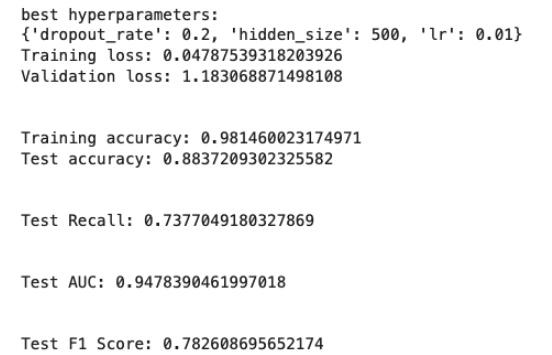

In [27]:
import sys
sys.path.append("../../app/model/")
import ModelNN as Net

In [28]:
X_train_df, X_test_df, y_train_df, y_test_df = pickle.load(open("../../data/train_test_data.pkl", "rb"))

In [29]:
# # open the parameters json
# import json

# file_path = "../../model/model_parameters.json"
# with open(file_path) as model_params:
#     model_params = json.load(model_params)

# model_params

In [30]:
# this was determined through two rounds of grid search
print(chosen_metric)
param_keys = ['dropout_rate', 'hidden_size', 'lr']
for key in param_keys:
    print(key + ":", best_params[key])
print(len(best_params['features']), " features: ")
print(best_params['features'])

recall_score
dropout_rate: 0.2
hidden_size: 10
lr: 0.0001
10  features: 
['peak_i15_mmh', 'kf', 'prophm23', 'SuscFrac', 'fire_interval', 'SAV', 'SedUn', 'Extinction moisture content', 'Fine fuel load', 'LNDS_RISKS']


In [31]:
# n_epochs = 750
n_epochs = n_epochs
print(n_epochs)

1000


Architecture:  OneLayer
10  features: 
['peak_i15_mmh', 'kf', 'prophm23', 'SuscFrac', 'fire_interval', 'SAV', 'SedUn', 'Extinction moisture content', 'Fine fuel load', 'LNDS_RISKS']
hyperparameters:
dropout_rate: 0.2
hidden_size: 10
lr: 0.0001


Epochs: 1000
Training loss: 0.49487099051475525
Validation loss: 0.5049611330032349


Training accuracy: 0.7734899328859061
Test accuracy: 0.7453874538745388


Precision (test): 0.20833333333333334


Recall (test): 0.09090909090909091


F1 Score (test): 0.12658227848101267


AUC (test): 0.7292087542087543


CPU times: user 1.5 s, sys: 60.1 ms, total: 1.56 s
Wall time: 1.49 s


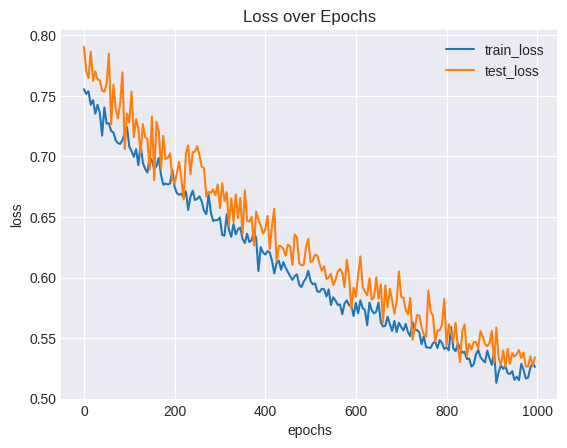

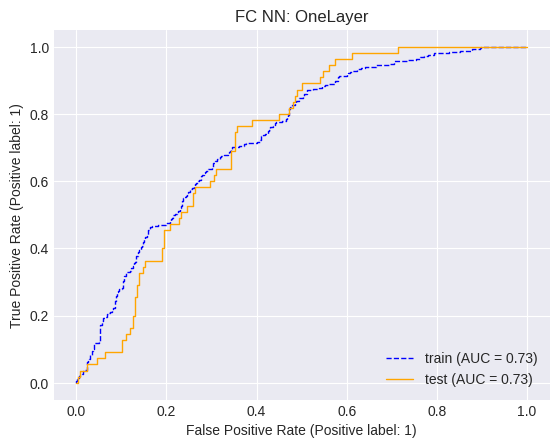

In [32]:
%%time
# TUNED TRAINING
if __name__ == '__main__':
    # Load data

    # splitting already conducted
    # using df objects to avoid tensor issues
    # and sticking with naming convention for feature subset selection
    X_train = X_train_df[best_params['features']]
    X_test = X_test_df[best_params['features']]
    y_train = y_train_df
    y_test = y_test_df

    #scale the data X_train and X_test
    cols = X_train.columns
    sc = StandardScaler()
    X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(sc.transform(X_test), columns=cols)
    
    # change datatype for pytorch
    # send to gpu if available
    X_train_tensor = torch.tensor(X_train.values).float().to(device)
    X_test_tensor = torch.tensor(X_test.values).float().to(device)
    y_train_tensor = torch.tensor(y_train.values).float().view(-1, 1).to(device)
    y_test_tensor = torch.tensor(y_test.values).float().view(-1, 1).to(device)
    
    # hyperparameters
    input_size = X_train.shape[1]
    hidden_size = best_params['hidden_size']
    learning_rate = best_params['lr'] # 0.001 is default value for Adam optimizer
    dropout_rate = best_params['dropout_rate']
    output_size = 1 # in our case this is always 0ne

    # select architecture
    # send to gpu if available
    model = Net.OneLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
    #model = Net.TwoLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
    #model = Net.ThreeLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
        
    # make sure model is in training mode, calculates gradients etcs
    model.train()
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    ## Train the Model ##
    
    # empty df to track loss over epochs
    loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])
    
    for epoch in range(n_epochs):
        y_train_pred_proba = model(X_train_tensor)
        loss = criterion(y_train_pred_proba, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%5 ==0:
            y_train_pred_proba = model(X_train_tensor)
            y_test_pred_proba = model(X_test_tensor)

            train_loss = criterion(y_train_pred_proba, y_train_tensor)
            val_loss = criterion(y_test_pred_proba, y_test_tensor)
            
            loss_df.loc[epoch, 'train_loss'] = train_loss.detach().cpu().numpy().flatten()[0]
            loss_df.loc[epoch, 'test_loss'] = val_loss.detach().cpu().numpy().flatten()[0]

    # turn off dropout etc
    model.eval()
    ## now "final" probability outputs from trained model ##
    y_train_pred_proba = model(X_train_tensor)
    y_test_pred_proba = model(X_test_tensor)     

    # loss on the final output
    # this isn't really meaningful without seeing change over epochs 
    # occasionally handy to reference
    train_loss = criterion(y_train_pred_proba, y_train_tensor).detach().cpu().numpy().flatten()[0]
    val_loss = criterion(y_test_pred_proba, y_test_tensor).detach().cpu().numpy().flatten()[0]

    # # convert these values back to pandas dtypes
    y_train_pred_proba = y_train_pred_proba.detach().cpu().numpy() # numpy goes back to cpu
    y_test_pred_proba = y_test_pred_proba.detach().cpu().numpy()  # numpy goes back to cpu
    # also get their boolean values
    y_train_pred_bool = np.round(y_train_pred_proba)
    y_test_pred_bool = np.round(y_test_pred_proba)

    # calculate accuracy
    train_accuracy = accuracy_score(y_train_df, y_train_pred_bool.flatten())
    test_accuracy = accuracy_score(y_test_df, y_test_pred_bool.flatten())

    # calculate precision
    test_precision = precision_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)
    
    # calculate recall
    test_recall_score = recall_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)
    
    # calculate f1
    f1_test = f1_score(y_test_df, y_test_pred_bool)

    # extract AUC for printing
    auc_test = roc_auc_score(y_test_df, y_test_pred_proba)  

    ##
    ## display performance summary ##
    ##
    model_name = model.__class__.__name__
    print(f'Architecture:  {model_name}')
    print(len(best_params['features']), " features: ")
    print(best_params['features'])
    print('hyperparameters:')
    for key in param_keys:
        print(key + ":", best_params[key])
    print("\n")
    print(f'Epochs: {n_epochs}')
    print(f'Training loss: {train_loss}')
    print(f'Validation loss: {val_loss}')
    print("\n")

    # accuracy
    print(f'Training accuracy: {train_accuracy}')
    print(f'Test accuracy: {test_accuracy}')
    print('\n')

    # precision
    print(f'Precision (test): {test_precision}')
    print('\n')    
    
    # recall
    print(f'Recall (test): {test_recall_score}')
    print('\n')

    # f1
    print(f'F1 Score (test): {f1_test}')
    print('\n')

    # AUC
    print(f'AUC (test): {auc_test}')
    print('\n')
    
    # to be saved to json
    # must convert float type for serialization
    performance_summary = {
        'train_loss': float(train_loss),
        'val_loss': float(val_loss),
        'train_accuracy': float(train_accuracy),
        'test_accuracy': float(test_accuracy),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall_score),
        'test_f1_score': float(f1_test),
        'test_auc': float(auc_test),
    }
    
    # PLOTS
    
    # Loss plot
    fig = loss_df.plot()
    fig.set_xlabel('epochs')
    fig.set_ylabel('loss')
    fig.set_title('Loss over Epochs');

    # AUC plot
    fig, ax = plt.subplots()

    RocCurveDisplay.from_predictions(y_train_df, 
                                     y_train_pred_proba, 
                                     ax=ax, 
                                     linewidth=1, 
                                     color='blue', 
                                     name='train', 
                                     linestyle="dashed"
                                    );

    RocCurveDisplay.from_predictions(y_test_df, 
                                     y_test_pred_proba,
                                     ax=ax, 
                                     linewidth=1, 
                                     color='orange', 
                                     name='test');

    plt.title(f'FC NN: {model_name}');

    # save final model weights
    # torch.save(model.state_dict(), f'../model/{model_name}.pth')

## Extract SHAP values from final model / feature subset

In [33]:
explainer = shap.DeepExplainer(model, X_train_tensor)
shap_values = explainer.shap_values(X_test_tensor)
print(shap_values.shape)
vals = np.abs(shap_values).mean(0)
shap_val_df = pd.DataFrame(data=vals, index=X_test.columns, columns=['vals'])
shap_val_df = shap_val_df.sort_values(by='vals', ascending=False)
shap_val_df

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


(271, 10)


,vals
Fine fuel load,0.045415
SedUn,0.040798
prophm23,0.040126
SAV,0.034625
fire_interval,0.026828
LNDS_RISKS,0.026796
kf,0.022264
Extinction moisture content,0.021035
SuscFrac,0.019885
peak_i15_mmh,0.019875


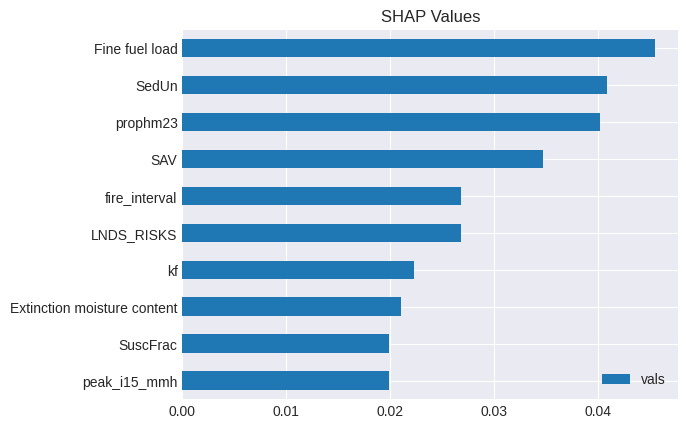

In [34]:
shap_val_df[::-1].plot(kind='barh', title='SHAP Values');

## save the model parameters
- architecture name + epochs
- features / hyperparameters
- weights and biases

In [35]:
# check if parameters file exists
# if not, create it
import os
import json

file_path = "../../app/model/model_parameters.json"
if os.path.isfile(file_path) == True:
    print("parameter json already exists")
else:
    print("created empty json file")
    model_params = {} # create empty dict
    with open(file_path, "w") as json_file:
        json.dump(model_params, json_file)

parameter json already exists


In [36]:
# open the parameters json
file_path = "../../app/model/model_parameters.json"
with open(file_path) as model_params:
    model_params = json.load(model_params)

# model_params

In [37]:
# save final model weights
architecture = model_name + "_" + str(n_epochs) + "_epochs" + "_optimized_" + chosen_metric
torch.save(model.state_dict(), f'../../app/model/{architecture}.pth')

# and hyperparameters
new_params = {}
new_params['features'] = best_params['features']
new_params['hidden_size'] = best_params['hidden_size']
new_params['lr'] = best_params['lr']
new_params['dropout_rate'] = best_params['dropout_rate']
new_params['epochs'] = n_epochs
new_params['model_class'] = model_name
new_params['weights'] = f'{architecture}.pth'
new_params['grid_search_metric'] = chosen_metric
new_params['performance_summary'] = performance_summary

# assign to the json
model_params[architecture] = new_params
# and view the final output
print(architecture)
model_params[architecture]

OneLayer_1000_epochs_optimized_recall_score


{'features': ['peak_i15_mmh',
  'kf',
  'prophm23',
  'SuscFrac',
  'fire_interval',
  'SAV',
  'SedUn',
  'Extinction moisture content',
  'Fine fuel load',
  'LNDS_RISKS'],
 'hidden_size': 10,
 'lr': 0.0001,
 'dropout_rate': 0.2,
 'epochs': 1000,
 'model_class': 'OneLayer',
 'weights': 'OneLayer_1000_epochs_optimized_recall_score.pth',
 'grid_search_metric': 'recall_score',
 'performance_summary': {'train_loss': 0.49487099051475525,
  'val_loss': 0.5049611330032349,
  'train_accuracy': 0.7734899328859061,
  'test_accuracy': 0.7453874538745388,
  'test_precision': 0.20833333333333334,
  'test_recall': 0.09090909090909091,
  'test_f1_score': 0.12658227848101267,
  'test_auc': 0.7292087542087543}}

In [38]:
# write out the file
file_path = "../../app/model/model_parameters.json"
with open(file_path, "w") as json_file:
    json.dump(model_params, json_file)
    print("hyperparameters saved!")

hyperparameters saved!


# Confusion Matrix <a id="MATRIX">
- assess probabilities
- is the loss for test set high due to outliers, particular states, etc

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [40]:
# bring in full file
# will need for geographic assessment of confusion matrix
file_path = "../../data/data_v08_consolidated.parquet"
df = gpd.read_parquet(file_path)

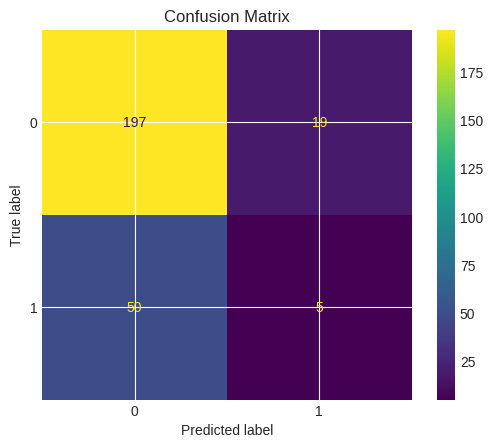

In [41]:
cm = confusion_matrix(y_test_df, y_test_pred_bool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();
plt.title('Confusion Matrix');

In [42]:
# pd.set_option('display.float_format', lambda x: '%.7f' % x)

In [43]:
# create dataframe with test values
test_assess = pd.DataFrame(y_test_df).astype(int).rename(columns={'response': 'y_test'})
# predicted values
test_assess['y_test_pred'] = y_test_pred_bool.flatten().astype(int)
# whether they are correctly predicted
test_assess['pred_correct'] = test_assess['y_test'] == test_assess['y_test_pred']
# the probability of the prediction
test_assess['y_test_pred_proba'] = y_test_pred_proba.flatten().astype(np.float16) # reduce precision to prevent downstream errors

# create column for confusion matrix
# we'll use this to assess the probabilities
# there's a dataframe for each of these if needed
TP = test_assess[(test_assess['y_test'] == 1) & (test_assess['pred_correct'] == True)]
FP = test_assess[(test_assess['y_test'] == 0) & (test_assess['pred_correct'] == False)]
TN = test_assess[(test_assess['y_test'] == 0) & (test_assess['pred_correct'] == True)]
FN = test_assess[(test_assess['y_test'] == 1) & (test_assess['pred_correct'] == False)]

test_assess.loc[TP.index,'confusion'] = 'TP'
test_assess.loc[FP.index,'confusion'] = 'FP'
test_assess.loc[TN.index,'confusion'] = 'TN'
test_assess.loc[FN.index,'confusion'] = 'FN'

# bring in the state values
test_assess = pd.merge(test_assess, df['state'], how='left', left_index=True, right_index=True)

test_assess

,y_test,y_test_pred,pred_correct,y_test_pred_proba,confusion,state
2,0,0,True,0.160522,TN,CA
6,0,0,True,0.223022,TN,CA
10,0,0,True,0.180298,TN,CA
29,1,0,False,0.462402,FN,ID
35,1,0,False,0.406250,FN,ID
...,...,...,...,...,...,...
1446,0,0,True,0.276123,TN,AZ
1447,0,0,True,0.388184,TN,AZ
1448,0,0,True,0.277344,TN,AZ
1449,0,0,True,0.245728,TN,AZ


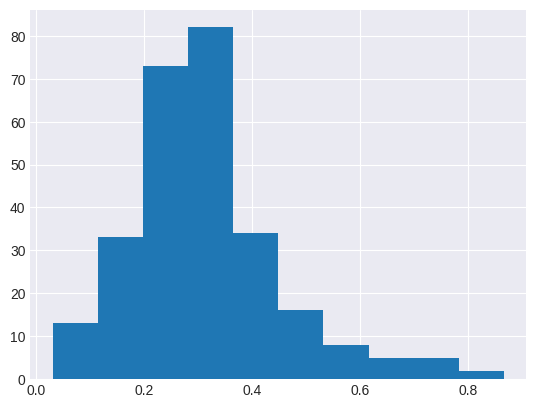

In [44]:
# overall probability distribution
test_assess['y_test_pred_proba'].hist();

In [45]:
# records were there was actually YES debris flow
subset = ['TP', 'FN']
flows = test_assess[test_assess['confusion'].isin(subset)]

# records were there was actually NO debris flow
subset = ['TN', 'FP']
no_flows = test_assess[test_assess['confusion'].isin(subset)]

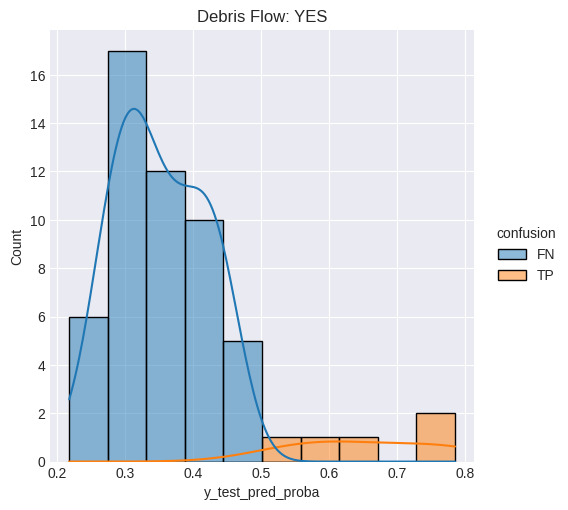

In [46]:
sns.displot(data=flows, x='y_test_pred_proba', hue='confusion', kde=True);
plt.title('Debris Flow: YES');

In [47]:
# # seaborn has a hard time with the really small probabilities
# sns.displot(data=no_flows, x='y_test_pred_proba', hue='confusion', kde=True);
# plt.title('Debris Flow: NO');

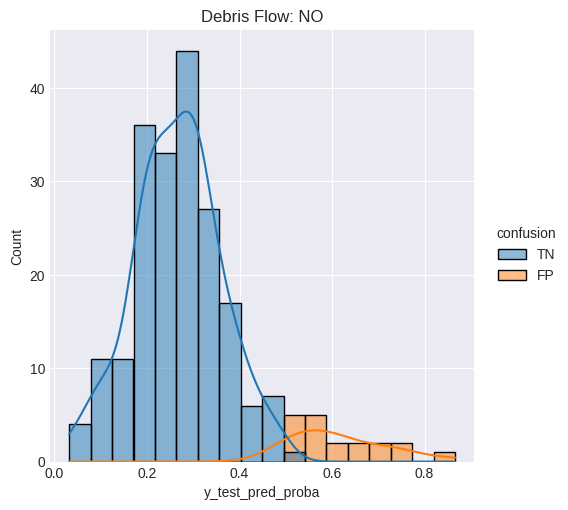

In [48]:
# seaborn has a hard time with the really small probabilities
temp = no_flows[no_flows['y_test_pred_proba'].astype(str).str.len() < 9]
sns.displot(data=temp, x='y_test_pred_proba', hue='confusion', kde=True);
plt.title('Debris Flow: NO');

In [49]:
# this let's us see where are performance is coming from
# it's the percentage of each metric by state
state_matrix = test_assess.groupby(['confusion'])['state'].value_counts(normalize=True).unstack().fillna(0)#.astype(int)
state_matrix = state_matrix.loc[['TP', 'FN', 'TN', 'FP'],:]
state_matrix

state,AZ,CA,CO,ID,MT,NM
confusion,,,,,,
TP,0.200000,0.000000,0.000000,0.000000,0.400000,0.400000
FN,0.040000,0.820000,0.100000,0.040000,0.000000,0.000000
TN,0.111675,0.543147,0.324873,0.005076,0.005076,0.010152
FP,0.263158,0.052632,0.210526,0.000000,0.263158,0.210526


In [50]:
test_assess['confusion'].value_counts()

TN    197
FN     50
FP     19
TP      5
Name: confusion, dtype: int64

In [51]:
# we can use this to determine
# is our confusion matrix is overindexing on certain state(s)
state_counts = test_assess['state'].value_counts(normalize=True).sort_index()
state_counts

AZ    0.110701
CA    0.549815
CO    0.269373
ID    0.011070
MT    0.029520
NM    0.029520
Name: state, dtype: float64

In [52]:
confusion_index = state_matrix.div(state_counts) - 1
confusion_index

state,AZ,CA,CO,ID,MT,NM
confusion,,,,,,
TP,0.806667,-1.000000,-1.000000,-1.000000,12.550000,12.550000
FN,-0.638667,0.491409,-0.628767,2.613333,-1.000000,-1.000000
TN,0.008799,-0.012128,0.206036,-0.541455,-0.828046,-0.656091
FP,1.377193,-0.904274,-0.218457,-1.000000,7.914474,6.131579


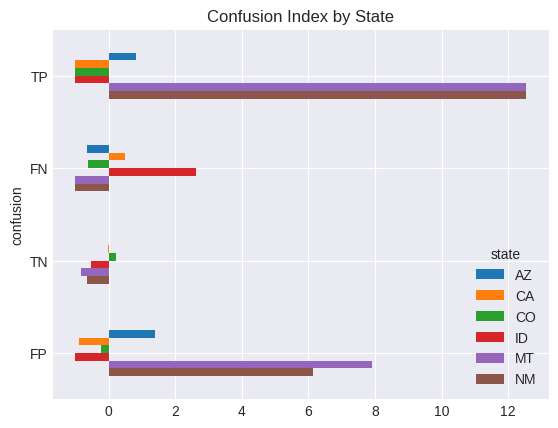

In [53]:
confusion_index.plot(kind='barh').invert_yaxis();
plt.title('Confusion Index by State');

In [54]:
# end of notebook
end_time = datetime.now()
print('end time:', str(end_time))
elapsed_time = end_time - start_time
print('elapsed time:', str(elapsed_time))

end time: 2023-06-08 00:10:24.273561
elapsed time: 0:19:01.325420
